In [1]:
import numpy as np
import datetime
from netCDF4 import Dataset
import itertools
import matplotlib.pyplot as plt
from matplotlib import gridspec
import tqdm
from scipy.stats import linregress
import warnings
warnings.filterwarnings("ignore")

In [2]:
# create days and dates list from 01/10/2010 - 30/04/2011
days_short = np.arange(0,212)
dates_short = [datetime.date(2010,10,1)+datetime.timedelta(days=np.int(days)) for days in days_short]
doys_short = np.array([x.timetuple().tm_yday for x in dates_short])
# create days and dates list from 01/01/2010 - 30/04/2021
days_long = np.arange(0,4138)
dates_long = [datetime.date(2010,1,1)+datetime.timedelta(days=np.int(days)) for days in days_long]
doys_long = np.array([x.timetuple().tm_yday for x in dates_long])

### load buoy data and create buoy climatology

In [3]:
datapath = '/Users/carmennab/Dropbox/alpha_retracker/data/validation/BGEP/'
bgep_a = np.asarray(Dataset(datapath+'ULS_A/SIT_EASE_01Jan2010-31Jul2021.nc')['Sea Ice Thickness'])[:4138]
bgep_b = np.asarray(Dataset(datapath+'ULS_B/SIT_EASE_01Jan2010-31Jul2021.nc')['Sea Ice Thickness'])[:4138]
bgep_d = np.asarray(Dataset(datapath+'ULS_D/SIT_EASE_01Jan2010-31Jul2021.nc')['Sea Ice Thickness'])[:4138]

In [4]:
days = np.arange(0,367)
buoya_avs = np.array([np.nanmean(bgep_a[doys_long==day]) for day in days])
buoyb_avs = np.array([np.nanmean(bgep_b[doys_long==day]) for day in days])
buoyd_avs = np.array([np.nanmean(bgep_d[doys_long==day]) for day in days])

buoy_clims = np.array([buoya_avs,buoyb_avs,buoyd_avs])
buoy_clim = np.nanmean(buoy_clims,axis=0) ### climatology

buoy_meanss = np.array([bgep_a,bgep_b,bgep_d])
buoy_means = np.nanmean(buoy_meanss,axis=0)  
buoy_anoms = np.array([buoy-buoy_clim[doy] for doy,buoy in zip(doys_long,buoy_means)])

### calculate optimal alpha at wind speeds

In [5]:
datapath = '/Users/carmennab/Dropbox/alpha_retracker/data/wind_speed/'
temp_a = np.array(Dataset(datapath + 'ERA5_wind_ULS_A.nc')['Wind Speed'])
temp_b = np.array(Dataset(datapath + 'ERA5_wind_ULS_B.nc')['Wind Speed'])
temp_d = np.array(Dataset(datapath + 'ERA5_wind_ULS_D.nc')['Wind Speed'])
temps = np.nanmean(np.array([temp_a,temp_b,temp_d]),axis = 0)

In [6]:
q = np.quantile(temps.ravel()[~np.isnan(temps.ravel())],q=np.arange(0,1.01,0.333333))

ns = []

cold_buoys = buoy_anoms.copy()
cold_buoys[temps >= q[1]] = np.nan 
cold_buoys[temps < q[0]] = np.nan 
cold_buoys[np.isnan(temps)] = np.nan
ns.append(cold_buoys[~np.isnan(cold_buoys)].shape[0])

warm_buoys = buoy_anoms.copy()
warm_buoys[temps>= q[2]] = np.nan 
warm_buoys[temps< q[1]] = np.nan 
warm_buoys[np.isnan(temps)] = np.nan
ns.append(warm_buoys[~np.isnan(warm_buoys)].shape[0])

hot_buoys = buoy_anoms.copy()
hot_buoys[temps > q[3]] = np.nan
hot_buoys[temps < q[2]] = np.nan 
hot_buoys[np.isnan(temps)] = np.nan
ns.append(hot_buoys[~np.isnan(hot_buoys)].shape[0])

In [7]:
#### one giant buoy
datapath = '/Users/carmennab/Dropbox/alpha_retracker/data/sit/'
names = ['CPOM','AWI']
alphas = np.arange(0,101)
all_hot = {}
all_warm = {}
all_cold = {}

for name in names:
    rs_hot = np.full(101,np.nan)
    rs_warm = np.full(101,np.nan)
    rs_cold = np.full(101,np.nan)
    for alpha in alphas:
        a = np.asarray(Dataset(datapath+'SMLG_'+name+'/ULS_A/a'+str(alpha)+'.nc')['Sea Ice Thickness'])
        b = np.asarray(Dataset(datapath+'SMLG_'+name+'/ULS_B/a'+str(alpha)+'.nc')['Sea Ice Thickness'])
        d = np.asarray(Dataset(datapath+'SMLG_'+name+'/ULS_D/a'+str(alpha)+'.nc')['Sea Ice Thickness'])

        ### create daily climatology for cs2
        cs2a_avs = np.array([np.nanmean(a[doys_long==day]) for day in days])
        cs2b_avs = np.array([np.nanmean(b[doys_long==day]) for day in days])
        cs2d_avs = np.array([np.nanmean(d[doys_long==day]) for day in days])
    
        cs2_clims = np.array([cs2a_avs,cs2b_avs,cs2d_avs])
        cs2_clim = np.nanmean(cs2_clims,axis=0) ### climatology
        
        cs2_meanss = np.array([a,b,d])
        cs2_means = np.nanmean(cs2_meanss,axis=0) ### giant cs2 data  
        
        ### create daily anomalies for cs2
        cs2_anoms = np.array([cs2-cs2_clim[doy] for doy,cs2 in zip(doys_long,cs2_means)]) 
        
        ### calculate alpha hot:  upper tercile
        mask_hot = ~np.isnan(hot_buoys) & ~np.isnan(cs2_anoms) 
        rstats = linregress(hot_buoys[mask_hot],cs2_anoms[mask_hot]) 
        p = rstats.pvalue
        if p <=0.05:
            rs_hot[alpha] = rstats.rvalue
                        
        ### calculate alpha warm: middle tercile
        mask_warm = ~np.isnan(warm_buoys) & ~np.isnan(cs2_anoms)

        rstats = linregress(warm_buoys[mask_warm],cs2_anoms[mask_warm]) 
        p = rstats.pvalue
        if p <=0.05:
            rs_warm[alpha] = rstats.rvalue

        ### calculate alpha cold: lower tercile
        mask_cold = ~np.isnan(cold_buoys) & ~np.isnan(cs2_anoms)
        rstats = linregress(cold_buoys[mask_cold],cs2_anoms[mask_cold]) 
        p = rstats.pvalue
        if p <=0.05:
            rs_cold[alpha] = rstats.rvalue
            
    rs_hot[rs_hot<0] = np.nan
    rs_warm[rs_warm<0] = np.nan
    rs_cold[rs_cold<0] = np.nan

    all_hot[name] = rs_hot
    all_warm[name] = rs_warm
    all_cold[name] = rs_cold

### plot figures showing all results

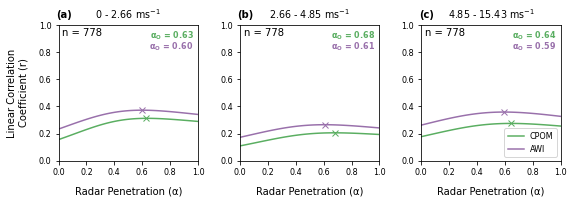

In [9]:
fig = plt.figure(figsize=(9,2.5))
plt.rc('font', size=8)
plt.rcParams.update({'mathtext.default':  'regular' })
spec = gridspec.GridSpec(ncols=3, nrows=1, wspace=0.3, hspace=0.45)
names = ['0 - 2.66 ms$^{-1}$','2.66 - 4.85 ms$^{-1}$','4.85 - 15.43 ms$^{-1}$']
nums = ['(a)','(b)','(c)']
rs = [all_cold,all_warm,all_hot]

for c,r in enumerate(rs):
    ax = plt.subplot(spec[c])
    ax.plot(alphas/100, r['CPOM'],label = 'CPOM',color='#5aae61')
    ax.plot((np.nanargmax(r['CPOM'])/100),np.nanmax(r['CPOM']),'x',color='#5aae61')
    ax.plot(alphas/100, r['AWI'],label = 'AWI',color='#9970ab')
    ax.plot((np.nanargmax(r['AWI'])/100),np.nanmax(r['AWI']),'x',color='#9970ab')
    ax.text(0.81, 0.9, f"\u03B1$_O$ = {(np.nanargmax(r['CPOM'])/100):.2f}", ha='center',color='#5aae61',
            weight='bold',transform = ax.transAxes)
    ax.text(0.81, 0.82, f"\u03B1$_O$ = {(np.nanargmax(r['AWI'])/100):.2f}", ha='center',color='#9970ab',
            weight='bold',transform = ax.transAxes)
    ax.text(0.04, 1.05,nums[c], ha='center',color='k',weight='bold',transform = ax.transAxes,fontsize=10)
    ax.text(0.17, 0.92,f"n = {ns[c]}", ha='center',color='k',transform = ax.transAxes,fontsize=10)
    
    ax.set_xlim([0,1])

    ax.set_title(names[c])

    ax.set_xlabel('Radar Penetration (\u03B1)',labelpad=10,fontsize=10)
    ax.set_ylim([0,1])
    if c == 0:
        ax.set_ylabel('Linear Correlation\nCoefficient (r)',labelpad=10,fontsize=10)
    
    if c == 2:
        ax.legend(loc='lower right')
           
plt.savefig('/Users/carmennab/Dropbox/Apps/Overleaf/Alpha Retracker/supp_figs/optimal_alpha_wind.jpg',
            bbox_inches = "tight", dpi = 400)